In [1]:
#from ipywidgets import interact, widgets
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import anuga
import numpy
import pandas
import numpy as np
from anuga.utilities import plot_utils as pu

# some annoying userwarning when opening excel files 
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

Chose the simulation to study. Check in the output directory for simulation names (take the sww name with .sww dropped)

In [80]:

#simulation_base = 'domain_flows_1990_20220605_211629'  # Qfactor = 0.5, max_area = 10000
#simulation_base = 'domain_flows_1990_20220606_203033'  # Qfactor = 1.0, max_area = 10000
#simulation_base = 'domain_flows_1990_20220606_230501'  # Qfactor = 1.5, max_area = 10000
#simulation_base = 'domain_flows_1990_20220607_093426'  # Qfactor = 2.5, max_area = 10000
simulation_base = 'domain_flows_1990_20220607_203823' # Qfactor = 3.0, max_area = 10000
#simulation_base = 'domain_flows_1990_20220608_195435'  # Qfactor = 2.5, max_area = 40000




In [81]:
pv = pu.get_output('output/'+simulation_base+'.sww')
pc = pu.get_centroids(pv)

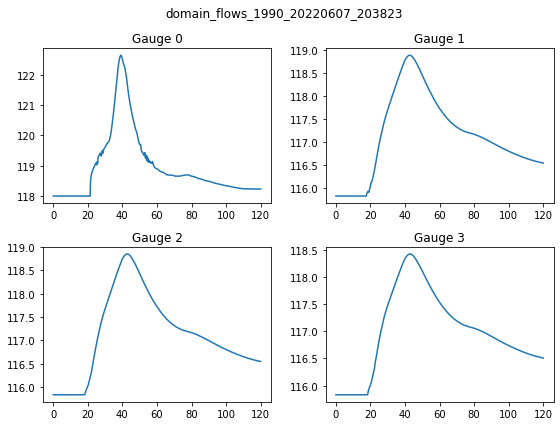

In [82]:
xll_corner = pv.xllcorner
yll_corner = pv.yllcorner

corner = np.array([xll_corner, yll_corner])

X = pc.x[:] + xll_corner
Y = pc.y[:] + yll_corner

elev = pc.elev[:]
stage = pc.stage[:,:]
vel = pc.vel[:,:]
mom = np.sqrt(pc.xmom[:,:]**2 + pc.ymom[:,:]**2)

gauge_points = [[248288, 6251012.0],
                [254752, 6219030],
                [267288, 6239628],
                [277600, 6248200]]

gauge_points = np.array(gauge_points)

fig, axs = plt.subplots(2, 2, figsize=(8,6))

starttime = pv.starttime

time_series_sec = pc.time[:]
time_series = pc.time[:]/3600

for i in range(3):
    for j in range(2):
        #print(j,i,2*i+j)
        try:
            g_id = 2*i+j
            tid = pu.get_triangle_containing_point(pv, gauge_points[g_id]-corner )
            #print(tid)
            stage_series = stage[:,tid]
            ax = axs[i,j]
            msg = 'Gauge %s'% g_id
            ax.plot(time_series, stage_series)
            ax.set(title=msg)
        except:
            pass

plt.suptitle(simulation_base)
fig.tight_layout()
plt.show()


Gauge Locations
------------------------

Gauge 3 corresponds to the dam wall. The next figure shows the location of the gauges. 

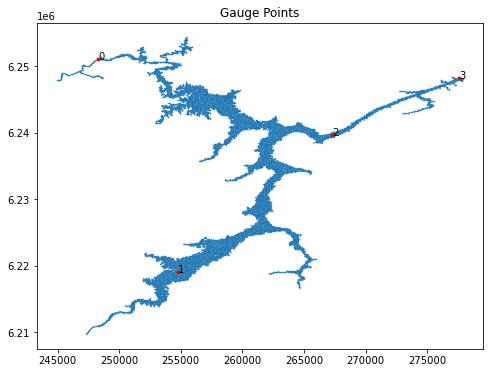

In [83]:
plt.figure(8, figsize=(8,6))
plt.clf()

gx = gauge_points[:,0]
gy = gauge_points[:,1]
msg = 'Gauge Points'
plt.title(msg)
plt.scatter(X, Y, s=0.1)
plt.scatter(gx,gy, s=8, c='red')
for i, (x,y) in enumerate(zip(gx,gy)):
    plt.annotate(str(i), (x,y), c='black')
    
#plt.xlim(277000,278000) # region close to guage 3
#plt.ylim(6247000,6248500)
plt.show()

Inflows
======

Now look at the applied inflows. The plots show the instantaneous inflows.

In [84]:
import json
with open('output/'+simulation_base+'_params.json', 'r') as fp:
    params = json.load(fp)

Qfactor = params['Qfactor']
flow_data = params['flow_data']
dam_height = params['dam_height']
reservoir_stage = params['reservoir_stage']
max_area = params['max_area']
yieldstep = params['yieldstep']
duration = params['duration']

from pprint import pprint
pprint(params)

import pandas
evolution_data = pandas.read_csv('output/'+simulation_base+'_outflow.csv')

{'Qfactor': 3.0,
 'dam_height': 116.0,
 'duration': 432000,
 'flow_data': 'flows_1990',
 'max_area': 10000,
 'reservoir_stage': 115.831,
 'yieldstep': 600}


In [85]:
# Data: [ Filename, lat, long, inlet radius, type, default flows ]
station_data = {
    212241: ['212241.xlsx', -33.87694444, 150.6063889, 100.0, 'outflow', (0.0, 0.0), 1.0, 'Discharge'],
    212250: ['212250.xlsx', -33.87124191, 150.2540137, 100.0, 'inflow', (10.0, 10.0), 1000.0/(3600*24),'Discharge'],
    212270: ['212270.xlsx', -34.22765922, 150.2527921, 1000.0, 'inflow', (10.0, 10.0), 1000.0/(3600*24),'Discharge'],
    212280: ['212280.xlsx', -34.14555579, 150.4247247, 1000.0, 'inflow', (2.0, 2.0), 1000.0/(3600*24),  'Discharge'],
    212260: ['212260.xlsx', -33.94805556, 150.2430556, 8000.0, 'inflow', (10.0, 10.0), 1000.0/(3600*24),'Discharge'],
    212243: ['212243.xlsx', -33.89111111, 150.5911111, 200.0, 'dam', (0.0, 0.0), 1.0, 'Depth']}

import utm

flow_operators = []

#================================
# The station time is based on
# a time base of 1900/1/1 == time 1 day
# We will convert to one based on 
# unix timestamp (1970/1/1)
#================================
from datetime import datetime
from zoneinfo import ZoneInfo
UTC = ZoneInfo('UTC')
data_time_base = datetime(1899, 12, 30, tzinfo=UTC)
data_base_timestamp = data_time_base.timestamp()

Setup outflow station  212241
Setup inflow station  212250
Setup inflow station  212270
Setup inflow station  212280
Setup inflow station  212260
Setup dam station  212243
Total inflows    9.86889e+08 
Total outflows   1.07283e+09 
Total flows      -8.59451e+07 


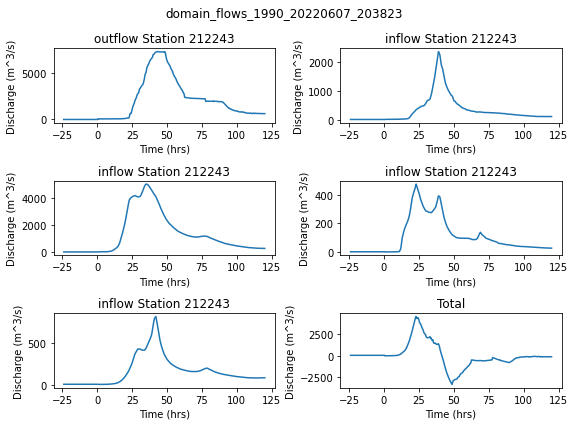

In [86]:
start_time = 1.0e200

data_dir = 'data/'+flow_data+'/'

outflow_stations = []
outflow_totals = []
inflow_stations = []
inflow_totals = []

fig, axs = plt.subplots(3, 2, figsize=(8,6))

axid = 0

outflow_operators = []
station_keys = []
q_in_s = []
q_out_s = []

start_time = 1.0e200
stations = []
station_key = []

from read_flow_data import read_flow_data

# ===================================
# Read in the flow timeseries and 
# return an interpolating function 
# ===================================
for key, value in station_data.items():
    
    station = read_flow_data(key, value, data_dir, data_base_timestamp)
    
    if station:
        stations.append(station)
        start_time = min(start_time, station['time_series'][0])
        #print(station['key'], station['flow'].shape)
        
        if station['type'] == 'inflow':
            inflow_totals.append(station['flow'])
            station_time_series = station['time_series']
            station_key.append(station['key'])
            
        if station['type'] == 'outflow':
            outflow_totals.append(station['flow'])
            
    
# ==================================
# Plot the results
# ==================================
for station in stations:

    if station['type'] == 'inflow' or station['type'] == 'outflow':
        
        t = numpy.linspace(start_time-3600*24,start_time+duration, 1000)
        q = station['Q_fun'](t)
        
        if station['type'] == 'inflow':
            q_in_s.append(q)
        else:
            q_out_s.append(q)
            
        t = (t - start_time)/3600

        #df.plot('Time', 'Discharge')
        #plt.show()

        ax = axs[axid//2 , axid%2]
        ax.plot(t,q)
        ax.set_title(station['type']+" Station "+str(key))
        ax.set_xlabel('Time (hrs)')
        ax.set_ylabel('Discharge (m^3/s)')
        
        #print(axid)
        axid += 1

#print('Outflows ', outflow_totals )
#print('Inflows ',  inflow_totals)

        
inflow_totals = numpy.array(inflow_totals)
outflow_totals = numpy.array(outflow_totals)
total_outflow = numpy.sum(outflow_totals)
total_inflow  = numpy.sum(inflow_totals)

#print(axid, axid//2, axid%2)
ax = axs[axid//2 , axid%2]


ax.set_title("Total")
ax.set_xlabel('Time (hrs)')
ax.set_ylabel('Discharge (m^3/s)')

print('Total inflows  ', ' %10.5e ' % total_inflow )
print('Total outflows ', ' %10.5e ' % total_outflow )
print('Total flows    ', ' %10.5e ' % (total_inflow - total_outflow) )

q_in_s = numpy.array(q_in_s)
q_in = numpy.sum(q_in_s,0)

q_out_s = numpy.array(q_out_s)
q_out = numpy.sum(q_out_s,0)


#ax.plot(t,q_in)
#ax.plot(t,q_out)
ax.plot(t,q_in-q_out)
      
plt.suptitle(simulation_base)
plt.tight_layout()
plt.show()

Q_out - Q_in = 1216558.9056706429
Q_out = 989361167.4444853
Q_in  = 988144608.5388147


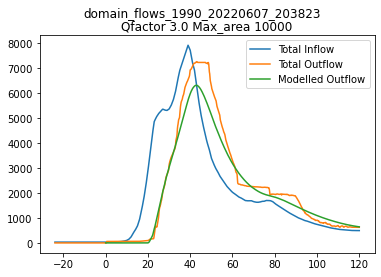

In [87]:
q_in_s = numpy.array(q_in_s)
q_out_s = numpy.array(q_out_s)

q_in_total = numpy.sum(q_in_s,0)

plt.plot(t,q_in_total, label='Total Inflow')
plt.plot(t,q_out_s[0,:], label='Total Outflow')


evol_time = evolution_data['time'].to_numpy()
evol_boundary_flux = evolution_data['boundary_flux'].to_numpy()

evol_time = (evol_time - evol_time[0])/3600
evol_boundary_flux[0] = evol_boundary_flux[1]
evol_time, evol_boundary_flux

plt.plot(evol_time, -np.gradient(evol_boundary_flux)/yieldstep, label='Modelled Outflow')

plt.legend()
plt.suptitle(simulation_base)
plt.title(f'Qfactor {Qfactor} Max_area {max_area}')
plt.savefig(simulation_base+'_dam_discharges.pdf')
#q_in_total


dt = (t[1]-t[0])*3600 # seconds
Q_in = q_in_total.sum()*dt
Q_out = q_out_s.sum()*dt

print('Q_out - Q_in =', Q_out - Q_in)
print('Q_out =',Q_out)
print('Q_in  =',Q_in)

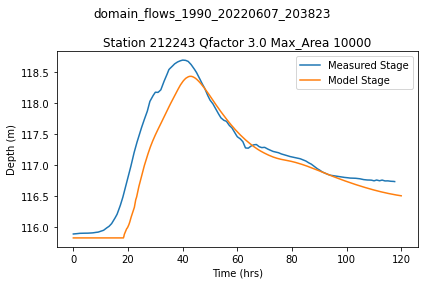

(721,)


In [88]:
for station in stations:

    if station['type'] == 'dam':
        
        t = numpy.linspace(start_time,start_time+3600*24*4.9, 1000)
        q = station['Q_fun'](t)

        t = (t - start_time)/3600



        #df.plot('Time', 'Discharge')
        #plt.show()

        #ax = axs[axid//2 , axid%2]
        plt.plot(t,q, label='Measured Stage')
        plt.title(f"Station {str(key)} Qfactor {Qfactor} Max_Area {max_area}")
        plt.xlabel('Time (hrs)')
        plt.ylabel('Depth (m)')
        
        #print(axid)
        
        axid += 1
        
#plt.plot
        
#outflow_totals = numpy.array(outflow_totals)
#print('Total outflows ', numpy.sum(outflow_totals))
tid = pu.get_triangle_containing_point(pv, gauge_points[3]-corner )
#print(tid)
stage_series = stage[:,tid]

data = {'time' : time_series, 'stage' : stage_series}
df = pandas.DataFrame(data)
df.to_csv(simulation_base+'_dam_flow.csv')

 
plt.plot(time_series, stage_series, label='Model Stage')
plt.legend()
        
plt.suptitle(simulation_base)
plt.tight_layout()
plt.savefig(simulation_base+'_dam_flow.pdf')

plt.show()

print(time_series.shape)

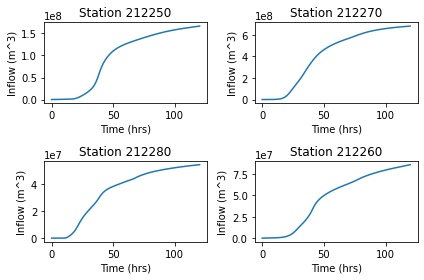

In [89]:
#plt.figure(5, figsize=(16,6))

fig, axs = plt.subplots(2, 2)#, figsize=(8,6))



station_time_series_0 = station_time_series - station_time_series[0]

for axid in range(4):
    ax = axs[axid//2 , axid%2]
    #ax.plot(t,q)
    
    cum_inflows = numpy.cumsum(inflow_totals[axid])
    ax.set_title("Station "+str(station_key[axid]))
    
    #print(axid, cum_inflows.shape, station_time_zeroed.shape, inflow_totals[axid].shape)
    ax.plot(station_time_series_0/3600, cum_inflows)
    ax.set_xlabel('Time (hrs)')
    ax.set_ylabel('Inflow (m^3)')

#print(inflow_totals[0])
    
fig.tight_layout()
plt.show();

In [90]:
station_key

[212250, 212270, 212280, 212260]

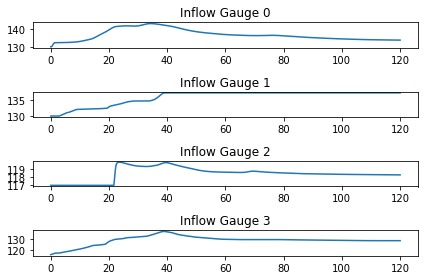

In [79]:
fig, axs = plt.subplots(4, 1) #, figsize=(8,6));

starttime = pv.starttime

inflow_gauges = np.array( [[ 247428.01966518, 6209922.80384708],
                 [ 253010.98684396, 6241406.61440706],
                 [ 265400, 6221070],
                 [ 246026.16802345, 6248664.34160264]])

inflow_gauges_rel = inflow_gauges - corner

time_series = (pc.time[:])/3600

inflow_tid = []

for i, inflow_gauge in enumerate(inflow_gauges_rel):
    tid = pu.get_triangle_containing_point(pv, inflow_gauge)
    #print(tid)
    inflow_tid.append(tid)
    stage_series = stage[:,tid]
    ax = axs[i]
    msg = 'Inflow Gauge %s'% i
    ax.plot(time_series, stage_series)
    ax.set(title=msg)
        
fig.tight_layout();
#plt.show()

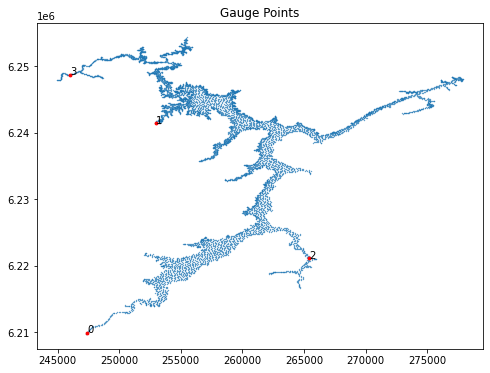

In [20]:
plt.figure(8, figsize=(8,6))
plt.clf()

gx = inflow_gauges[:,0]
gy = inflow_gauges[:,1]
msg = 'Gauge Points'
plt.title(msg)
plt.scatter(X, Y, s=0.1)
plt.scatter(gx,gy, s=8, c='red')
for i, (x,y) in enumerate(zip(gx,gy)):
    plt.annotate(str(i), (x,y), c='black')
    
plt.show()